# Alternating Least Square Formulation Recommender Systems
Simple user and item latent factor based matrix factorization algorithm
Dataset used: MovieLens dataset
Source: https://grouplens.org/datasets/movielens/
Algo is coded for very small datasets

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [156]:
#Loading MovieLens Dataset
tags = pd.read_csv('MovieLens Data/ml-20m/tags.csv')
ratings = pd.read_csv('MovieLens Data/ml-20m/ratings.csv', sep=',')
movies = pd.read_csv('MovieLens Data/ml-20m/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [166]:
movies = movies.iloc[0:2000,:]

In [167]:
movie_titles = movies.title.tolist()

In [168]:
print(tags.columns)
print(ratings.columns)
print(movies.columns)

Index(['userId', 'movieId', 'tag', 'timestamp'], dtype='object')
Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')
Index(['movieId', 'title', 'genres'], dtype='object')


In [169]:
#Create a combined movie dataframe
#And remove unnecessary columns
df = movies.join(ratings, on = ['movieId'],rsuffix='_r').join(tags, on =['movieId'],rsuffix = '_t').drop(['movieId_r','userId_t','movieId_t','timestamp_t'], axis=1)

In [170]:
#Create a ratings table for all userId and movieId, and fill not rated movies with 0
rp = df.pivot_table(columns=['movieId'],index=['userId'],values='rating').fillna(0)
print(rp.shape)
#Thus 718 users and 27278 items in ratings table rp
rp.head()

(19, 2000)


movieId,1,2,3,4,5,6,7,8,9,10,...,2074,2075,2076,2077,2078,2079,2080,2081,2082,2083
userId,,,,,,,,,,,,,,,,,,,,,
1,3.5,3.5,3.5,3.5,3.5,4.0,4.0,4.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [171]:
#Define matrixes and parameters 
Q = rp.values #Output ratings matrix
W = Q>0.5 # Mask matrix where user have given a rating
W[W==True] = 1
W[W==False] = 0
W = W.astype(np.float64, copy=False)
lambda_ = 0.1 #Regularization parameter
n_factors = 100 #Number of features or number of latent factors
m, n = Q.shape #m-- number of users, n-- number of movies
n_iterations = 20 #number of iterations

In [172]:
#Recommender class
class ALS:
    def __init__(self, W, lambda_ =0.01, n_iterations= 20, n_factors =100):
        self.mask = W
        self.lambda_ =lambda_
        self.n_iterations =n_iterations
        self.n_factors = n_factors

    def LSE_error(self,Q, pred):
        return np.sum((self.mask * (Q - pred))**2)

    def fit(self, Q, show =False):
        import numpy as np
        #Initialization
        X = 5 * np.random.rand(Q.shape[0], self.n_factors)
        Y = 5 * np.random.rand(self.n_factors, Q.shape[1])
        self.weighted_errors = []
        for ii in range(self.n_iterations):
            for u, Wu in enumerate(self.mask):
                X[u] = np.linalg.solve(np.dot(Y, np.dot(np.diag(Wu), Y.T)) + self.lambda_ * np.eye(self.n_factors),np.dot(Y, np.dot(np.diag(Wu), Q[u].T))).T
            for i, Wi in enumerate(self.mask.T):
                Y[:,i] = np.linalg.solve(np.dot(X.T, np.dot(np.diag(Wi), X)) + self.lambda_ * np.eye(self.n_factors),np.dot(X.T, np.dot(np.diag(Wi), Q[:, i])))
            self.weighted_errors.append(self.LSE_error(Q, np.dot(X,Y)))
            if(show==True):
                print('{}th iteration is completed'.format(ii))
        self.coefX = X
        self.coefY = Y
        self.Q_hat = np.dot(X,Y)
        return self

    def predict_recommendation(self, userIds, movie_titles=movie_titles):
        from collections import namedtuple
        self.Q_hat -= np.min(self.Q_hat)
        self.Q_hat *= float(5) / np.max(self.Q_hat)
        movie_ids = np.argmax(self.Q_hat - 5 * self.mask, axis=1)
        movie_ids = [movie_ids[ind-1] for ind in userIds]
        recommendation = []
        for user_id, movie_id in zip(userIds, movie_ids):
            Recommendation = namedtuple('Recommendation', 'UserId MovieId MovieTitle PredictedRating')
            Recommendation.UserId = user_id
            Recommendation.MovieId = movie_id
            Recommendation.MovieTitle = movie_titles[movie_id-1]
            Recommendation.PredictedRating = self.Q_hat[user_id-1][movie_id-1]
            recommendation.append(Recommendation)
        return recommendation

In [173]:
#Model fitting
als = ALS(W)
model = als.fit(Q, show=True)

0th iteration is completed
1th iteration is completed
2th iteration is completed
3th iteration is completed
4th iteration is completed
5th iteration is completed
6th iteration is completed
7th iteration is completed
8th iteration is completed
9th iteration is completed
10th iteration is completed
11th iteration is completed
12th iteration is completed
13th iteration is completed
14th iteration is completed
15th iteration is completed
16th iteration is completed
17th iteration is completed
18th iteration is completed
19th iteration is completed


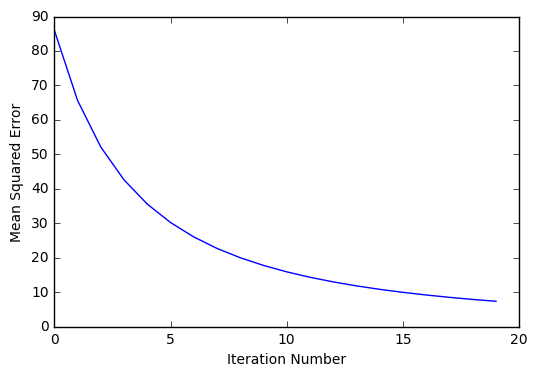

In [174]:
#Plot error vs iteration
plt.plot(model.weighted_errors);
plt.xlabel('Iteration Number');
plt.ylabel('Mean Squared Error');
plt.show()

In [177]:
#Recommendation
prediction = model.predict_recommendation(movie_titles=movie_titles, userIds=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])
for pred in prediction:
    print('UserID: {}'.format(pred.UserId))
    print('Recommendation')
    print('MovieId: {}'.format(pred.MovieId))
    print('MovieTitle: {}'.format(pred.MovieTitle))
    print('Predicted Rating: {}'.format(pred.PredictedRating))
    print('----------------')

UserID: 1
Recommendation
MovieId: 1427
MovieTitle: That Old Feeling (1997)
Predicted Rating: 1.0519001819859586
----------------
UserID: 2
Recommendation
MovieId: 513
MovieTitle: Renaissance Man (1994)
Predicted Rating: 0.8614111706924718
----------------
UserID: 3
Recommendation
MovieId: 1977
MovieTitle: BASEketball (1998)
Predicted Rating: 0.7981074247409237
----------------
UserID: 4
Recommendation
MovieId: 513
MovieTitle: Renaissance Man (1994)
Predicted Rating: 1.5693882099046723
----------------
UserID: 5
Recommendation
MovieId: 435
MovieTitle: Cowboy Way, The (1994)
Predicted Rating: 2.147011468127358
----------------
UserID: 6
Recommendation
MovieId: 946
MovieTitle: They Made Me a Criminal (I Became a Criminal) (They Made Me a Fugitive) (1939)
Predicted Rating: 1.8005324525172677
----------------
UserID: 7
Recommendation
MovieId: 910
MovieTitle: All About Eve (1950)
Predicted Rating: 1.7745897239571413
----------------
UserID: 8
Recommendation
MovieId: 871
MovieTitle: Talk of A